# **Probability and Random Processes: Assignment 2**
This Assignment is based on two algorithms.
1. Viola Jones Algorithm for Face Detection
2. Method of Eigenfaces for Face Recognition

To setup the data and the supporting functions, run the cells to import the libraries and clone the github repository.

In [1]:
### IMPORTING THE LIBRARIRES ###

from PIL import Image
import cv2
import numpy as np
import os
import shutil
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from tqdm import tqdm

!git clone --quiet https://github.com/uditvyas/Face_Recognition.git

# Part 1: Viola Jones Algorithm for Face Detection (Training Haar Classifier)

For this part, we need to extract both the positive and the negative images from the cloned repository. After this, we need to create the info files for both the positive and the negative files. The following code block produce the result.

**NOTE**: Run the next code cell **ONLY if** you wish to reproduce the results of training the Haar Classifier (training takes approx. 2 hours). Otherwise, **the Classifier file is already available in the cloned github repository**.

In [ ]:
# Checking if already exists
if os.path.exists('/content/pos'):
    shutil.rmtree('/content/pos')
if os.path.exists('/content/neg'):
    shutil.rmtree('/content/neg')

# Unzipping the data files
!unzip -q /content/Face_Recognition/negative.zip
!unzip -q /content/Face_Recognition/positive.zip

# Creating the data information files
def create_pos_n_neg():
    for file_type in ['neg','pos']:
        
        for img in os.listdir(file_type):

            if file_type == 'pos':
                line = file_type+'/'+img+' 1 0 0 62 47\n'
                with open('pos.lst','a') as f:
                    f.write(line)
            elif file_type == 'neg':
                line = file_type+'/'+img+'\n'
                with open('neg.dat','a') as f:
                    f.write(line)
create_pos_n_neg()

if os.path.exists('data'):
    shutil.rmtree('data')
os.mkdir('data')

# This command needs to installed in, if implementing in a local machine
# !apt-get install libopencv-dev

# Creating the Vector File
!opencv_createsamples -info pos.lst -num 3240 -w 100 -h 100 -vec positives.vec
# Training the Haar Classifier
!opencv_traincascade -data data -vec positives.vec -bg neg.dat -numPos 1500 -numNeg 750 -numStages 4 -w 100 -h 100

# Part 2: Detecting faces using the Haar Classifier

The below Code block extracts the images from the zip files.

After this, the Opencv Cascade Classifier function uses the Haar Classifier (.xml file), which was trained in the above code block.

All the images are then passed through the face detector and then are cropped based on the classifier's output. The cropped images are then appended to the final dataset of images and corresponding labels, which are ready to be classified using eigen faces algorithm

In [2]:
### EXTRACTING THE IMAGES ###

### MIT FACE DATASET ###
if os.path.exists('/content/pos'):
    shutil.rmtree('/content/pos')

print("Downloading Data....")
!unzip -q /content/Face_Recognition/positive.zip

################################################################################

images = []
labels = []

h = 50
w = 50

face_cascade = cv2.CascadeClassifier('/content/Face_Recognition/pre_trained_classifier.xml')
for name in tqdm(os.listdir('/content/pos')):
    img = cv2.imread("/content/pos/"+name,cv2.IMREAD_GRAYSCALE)
    face = list(face_cascade.detectMultiScale(img,1.3,5))
    if face:    
        face = face[0]
        x,y,height,width = face[0],face[1],face[2],face[3],
        img = img[y:y+height,x:x+width]
        img = cv2.resize(img,(h,w))
        img = img.flatten()
        images.append(img)
        label = int(name.split(".")[0])//324
        labels.append(label)
images = np.array(images)
labels = np.array(labels)

print("\nFaces Detected in Images Array: {}".format(images.shape))
print("Labels of Detected Images: {}".format(labels.shape))

## THE DATASET IS READY FOR DETECTION

100%|██████████| 3240/3240 [00:12<00:00, 257.70it/s]


Faces Detected in Images Array: (3173, 2500)
Labels of Detected Images: (3173,)


NOTE: The program involves an inherent assumption that the Haar Classifier used is 100% accurate. This approach is not a robust method. However, evaluating the accuracy of the Haar classifier is beyond the scope of this assignment.

# Part 3: Classification of Detected Faces using Eigenfaces

From the detected faces in the above step, we split the images and labels into training and testing set.

In [3]:
### SPLITTING THE IMAGES INTO TRAIN AND TEST DATASETS

X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.20)

print("X_train dimension: {}".format(X_train.shape))
print("y_train dimension: {}".format(y_train.shape))
print("X_test dimension: {}".format(X_test.shape))
print("y_test dimension: {}".format(y_test.shape))

X_train dimension: (2538, 2500)
y_train dimension: (2538,)
X_test dimension: (635, 2500)
y_test dimension: (635,)


The below code block does the following -

1. Find the mean face
2. Normalise the training data
3. Find the covariance matrix
4. Find the eigenvalues and eigenvectors
5. Sort the eigenvectors in the order of decreasing eigenalues

In [4]:
### CALCULTAING MEAN FACE AND IMPLEMENTING PRINCIPLE COMPONENT ANALYSIS

mean_face = np.mean([X_train[i] for i in range(len(X_train))],axis=0)
print("Mean Face Dimensions:{}".format(mean_face.shape))

normalised_X_train = X_train - mean_face
print("Normalised Faces Dimensions: {}".format(normalised_X_train.shape))

# cov_matrix = (1/normalised_X_train.shape[0])*np.cov(normalised_X_train)
cov_matrix = np.cov(normalised_X_train)
eigenvalues, eigenvectors = np.linalg.eig(cov_matrix)
print("Cov Matrix Dimensions: {}".format(cov_matrix.shape))
print("Eigenvalues of Cov Dimensions: {}".format(eigenvalues.shape))
print("Eigenvectors of Cov Dimensions: {}".format(eigenvectors.shape))

eig_pairs = [(eigenvalues[index], eigenvectors[:,index]) for index in range(len(eigenvalues))]

# Sort the eigen pairs in descending order:
eig_pairs.sort(reverse=True)
sorted_values  = np.array([eig_pairs[index][0] for index in range(len(eigenvalues))])
sorted_vectors = np.array([eig_pairs[index][1] for index in range(len(eigenvalues))])

print("Sorted Eigenvectors Dimensions: {}".format(sorted_values.shape))
print("Sorted Eigenvalues Dimensions: {}".format(sorted_vectors.shape))

Mean Face Dimensions:(2500,)
Normalised Faces Dimensions: (2538, 2500)
Cov Matrix Dimensions: (2538, 2538)
Eigenvalues of Cov Dimensions: (2538,)
Eigenvectors of Cov Dimensions: (2538, 2538)
Sorted Eigenvectors Dimensions: (2538,)
Sorted Eigenvalues Dimensions: (2538, 2538)


After the sorting of eigenvalues and eigenvectors is completed, we now plot the cumulative variance of the eigenvalues to decide upon the number of eigenvectors to be retained after Principle Component Analysis (PCA)

/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:138: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order, subok=True)


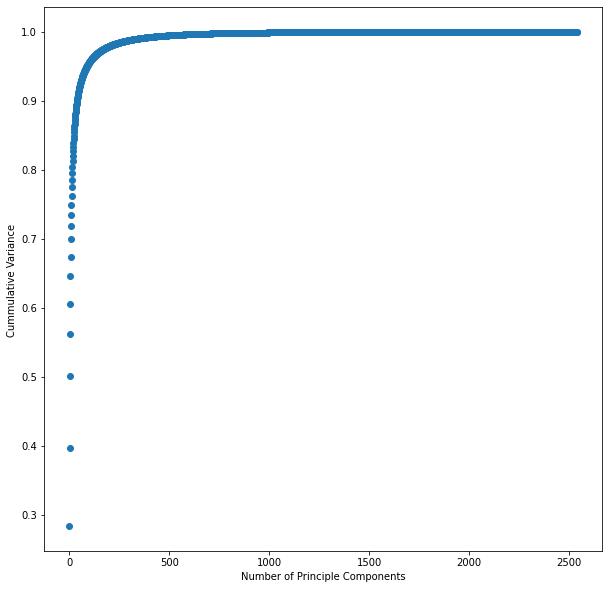

In [5]:
### DECIDING THE NUMBER OF PRINCIPLE COMPONENTS

# Finding Cumulative Sum of eigenvalues
cummulative_sum = np.cumsum(sorted_values)/np.sum(sorted_values)

x_axis = range(1,len(sorted_values)+1)
plt.figure(figsize=(10,10))
plt.scatter(x_axis, cummulative_sum)
plt.xlabel("Number of Principle Components")
plt.ylabel("Cummulative Variance ")
plt.show()

Based on the graph, choose an appropriate value of K. Then, reduce the data by finally applying the last step of PCA. At the end of this block, we have the final reduced eigenvectors from the data.

In [6]:
### REDUCING THE DATA ###
K = 300

reduced_data = np.array(sorted_vectors[:K]).transpose()
print("Reduced Data Dimensions: {}".format(reduced_data.shape))

final_eigen_vectors = np.dot(normalised_X_train.transpose(),reduced_data)
print("Final Eigen Vectors Dimensions: {}".format(final_eigen_vectors.shape))

# Finding weights for each training image
train_weights = np.array([np.dot(i,final_eigen_vectors) for i in normalised_X_train])
print("Train Weights Dimensions: {}".format(train_weights.shape))

final_eigen_vectors = np.transpose(final_eigen_vectors)

### FINAL EIGENVECTORS ARE READY ###

Reduced Data Dimensions: (2538, 300)
Final Eigen Vectors Dimensions: (2500, 300)
Train Weights Dimensions: (2538, 300)


The below is a helper function for calculating the accuracy of the eigenfaces approach

In [7]:
def display_compare(test_img,predicted_index,test_index,pred_labels):
    test_img = np.reshape(test_img,(-1,100))
    actual_label = y_test[test_index]

    predicted_image = np.reshape(X_train[predicted_index],(-1,100))
    predicted_label = y_train[predicted_index]
    pred_labels.append(predicted_label)

    if predicted_label == actual_label:
        return 1
    else:
        return 0   

# Part 4: Testing the algorithm for accuracy

In [8]:
correct = 0

pred_labels = []

for i in tqdm(range(len(X_test))):
    img = X_test[i]
    norm_img = img - mean_face
    weights = np.array([np.dot(norm_img,final_eigen_vectors[k]) for k in range(final_eigen_vectors.shape[0])])
    weight_error = train_weights - weights
    norms = np.linalg.norm(weight_error,axis = 1)
    predicted_index = np.argmin(norms)
    correct = correct + display_compare(img,predicted_index,i,pred_labels)

accuracy = correct*100/(i+1)
print("\nAccuracy: {:.2f}%".format(accuracy))
pred_labels = np.array(pred_labels)

100%|██████████| 635/635 [00:11<00:00, 56.15it/s]


Accuracy: 87.72%


# Part 5: Visualising the Predictions

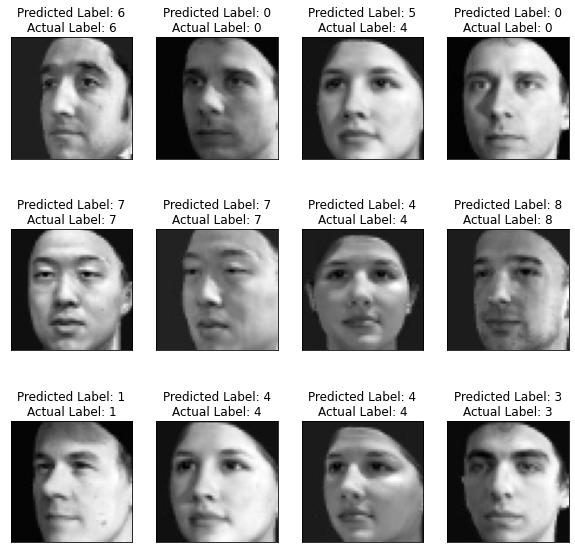

In [9]:
# Visualization
def plot_gallery(images, pred_labels, actual_labels, h, w, rows=3, cols=4):
    plt.figure(figsize = (10,10))
    for i in range(rows * cols):
        plt.subplot(rows, cols, i + 1)
        plt.imshow(np.reshape(images[i],(-1, h)), cmap=plt.cm.gray)
        plt.title("Predicted Label: {}\nActual Label: {}".format(pred_labels[i],actual_labels[i]))
        plt.xticks(())
        plt.yticks(())

plot_gallery(X_test, pred_labels, y_test, h, w)

# Part 6: Visualising the Mean Face and the Eigenfaces

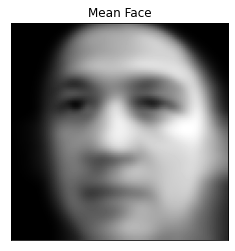

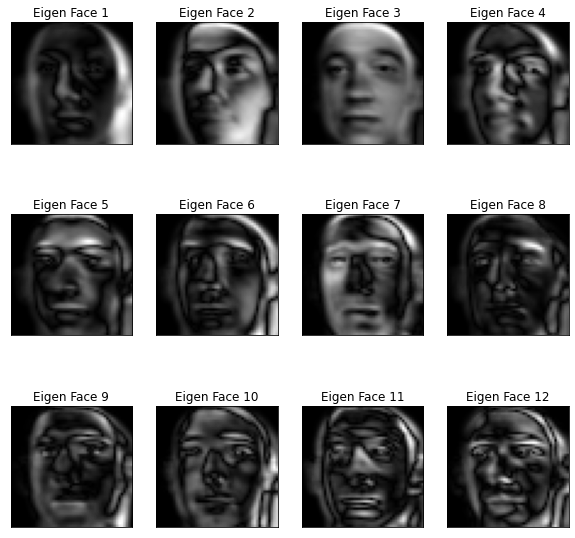

In [10]:
# Mean Face

mean_face_2d = np.reshape(mean_face,(-1,h))
mean_face_2d_resized = cv2.resize(mean_face_2d,(100,100))
plt.imshow(mean_face_2d_resized,cmap=plt.cm.gray)
plt.title("Mean Face")
plt.xticks(())
plt.yticks(())

# Eigenfaces
# Displaying Top 12 Eigenfaces

plt.figure(figsize = (10,10))
rows = 3
cols = 4
for i in range(rows * cols):
    plt.subplot(rows, cols, i + 1)
    plt.imshow(np.reshape(np.absolute(final_eigen_vectors[i]),(-1, h)), cmap=plt.cm.gray)
    plt.title("Eigen Face {}".format(i+1))
    plt.xticks(())
    plt.yticks(())